In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter
import dataframe_image as dfi # for saving styled data frame print-out table as png

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 3)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/plot.py

## Input

In [4]:
chain = 'Avalanche'

In [5]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('Fees'):
        fnames['Fees'] = fname
    if fname.startswith('Open Interest'):
        fnames['Open Interest'] = fname
fnames

{'Fees': 'Fees_2021-12-22_2022-09-07.csv',
 'Open Interest': 'Open Interest_2021-12-22_2022-09-07.csv'}

In [6]:
# create input-dependent dirs
save_fig_dir = os.path.join(png_dir, chain)
os.makedirs(save_fig_dir, exist_ok=True)

## Prep Fees Data

In [7]:
# only read the first 7 cols since the last col "Cumulative" is NOT the daily total, but cumulative daily total, 
# which we don't want.
df_fees = pd.read_csv(os.path.join(data_dir, chain, fnames['Fees']), 
                      parse_dates=['Date'], index_col='Date', usecols=range(6))
df_fees.columns = df_fees.columns.str.lower().str.replace(' ', '_') + '_fees'

# calc daily fees from traders
df_fees['trader_fees'] = df_fees.margin_trading_fees + df_fees.liquidation_fees

print(df_fees.info())
df_fees.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2021-12-22 to 2022-09-07
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   swap_fees            253 non-null    float64
 1   margin_trading_fees  253 non-null    float64
 2   mint_glp_fees        253 non-null    float64
 3   burn_glp_fees        253 non-null    float64
 4   liquidation_fees     253 non-null    float64
 5   trader_fees          253 non-null    float64
dtypes: float64(6)
memory usage: 13.8 KB
None


,swap_fees,margin_trading_fees,mint_glp_fees,burn_glp_fees,liquidation_fees,trader_fees
Date,,,,,,
2021-12-22,0.1252,0.0241,3.7963,0.0000,0.0000,0.0241
2021-12-27,0.0788,0.2072,0.0000,0.0000,0.0000,0.2072
2021-12-30,0.0460,1.1119,1.2279,0.0000,0.0000,1.1119
2021-12-31,0.0000,0.6245,0.0000,0.0000,0.0000,0.6245
2022-01-02,0.1276,0.9837,0.0418,0.0039,0.0000,0.9837


## Prep Open Interest Data

In [8]:
df_oi = pd.read_csv(os.path.join(data_dir, chain, fnames['Open Interest']), parse_dates=['Date'], index_col='Date') # , usecols=range(6)
df_oi.columns = df_oi.columns.str.lower()
df_oi = df_oi.assign(pct_short = lambda x: x.short / (x.short + x.long),
                     pct_long  = lambda x: x.long / (x.short + x.long))
print(df_oi.info())
df_oi.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2021-12-22 to 2022-09-07
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   short      253 non-null    float64
 1   long       253 non-null    float64
 2   pct_short  253 non-null    float64
 3   pct_long   253 non-null    float64
dtypes: float64(4)
memory usage: 9.9 KB
None


,short,long,pct_short,pct_long
Date,,,,
2021-12-22,10.9824,13.0705,0.4566,0.5434
2021-12-27,56.5863,150.8808,0.2727,0.7273
2021-12-30,56.5863,453.9116,0.1108,0.8892
2021-12-31,56.5863,150.8808,0.2727,0.7273
2022-01-02,10.9824,68.2145,0.1387,0.8613


## Join Data and Prep and Roll Up to Weekly

In [9]:
df = df_fees.loc[:, ['trader_fees']].join(df_oi.loc[:, ['pct_short', 'pct_long']])

if chain == 'Avalanche':
    df = df.loc['2022-01-07':, :] # all days before have tiny numbers, probably before official launch or people don't know

df = df.iloc[:-1, :] # drop the last row because the most recent date may not be a full day
df.head()

,trader_fees,pct_short,pct_long
Date,,,
2022-01-07,"10,137.6332",0.1330,0.8670
2022-01-08,"12,496.2306",0.5702,0.4298
2022-01-09,"79,978.7676",0.7736,0.2264
2022-01-10,"128,827.8689",0.5705,0.4295
2022-01-11,"111,593.3481",0.1781,0.8219


In [10]:
# approximate daily fees from longs and shorts
df = df.assign(fees_short = lambda x: x.trader_fees * x.pct_short, 
               fees_long  = lambda x: x.trader_fees * x.pct_long)
df.head()

,trader_fees,pct_short,pct_long,fees_short,fees_long
Date,,,,,
2022-01-07,"10,137.6332",0.1330,0.8670,"1,348.7537","8,788.8795"
2022-01-08,"12,496.2306",0.5702,0.4298,"7,125.3192","5,370.9115"
2022-01-09,"79,978.7676",0.7736,0.2264,"61,872.0519","18,106.7157"
2022-01-10,"128,827.8689",0.5705,0.4295,"73,498.5888","55,329.2801"
2022-01-11,"111,593.3481",0.1781,0.8219,"19,872.2665","91,721.0816"


In [11]:
# we have two years data so we use year and week numbers (1 to 52)
year_week = df.index.isocalendar().drop('day', axis=1)
df = pd.concat([year_week, df], axis=1)
df.head()

,year,week,trader_fees,pct_short,pct_long,fees_short,fees_long
Date,,,,,,,
2022-01-07,2022,1,"10,137.6332",0.1330,0.8670,"1,348.7537","8,788.8795"
2022-01-08,2022,1,"12,496.2306",0.5702,0.4298,"7,125.3192","5,370.9115"
2022-01-09,2022,1,"79,978.7676",0.7736,0.2264,"61,872.0519","18,106.7157"
2022-01-10,2022,2,"128,827.8689",0.5705,0.4295,"73,498.5888","55,329.2801"
2022-01-11,2022,2,"111,593.3481",0.1781,0.8219,"19,872.2665","91,721.0816"


In [12]:
# roll up to weekly level
da = (df.groupby(['year', 'week']).sum().loc[:, ['fees_short', 'fees_long']]
        .assign(pct_short = lambda x: x.fees_short * 100 / (x.fees_short + x.fees_long),
                pct_long  = lambda x: x.fees_long * 100 / (x.fees_short + x.fees_long)))
da.head(10)

fees_short    fees_long  pct_short  pct_long
year week                                               
2022 1     70,346.1247  32,266.5067    68.5550   31.4450
     2    183,616.9505 473,702.2557    27.9342   72.0658
     3    459,335.8861 616,173.0157    42.7087   57.2913
     4    427,243.0066 354,766.0562    54.6340   45.3660
     5    462,518.7254 244,211.1466    65.4449   34.5551
     6    189,482.3764 303,084.9489    38.4683   61.5317
     7     82,885.5957 123,818.6139    40.0986   59.9014
     8    318,646.1478 369,946.3820    46.2750   53.7250
     9    165,737.4425 272,814.7978    37.7919   62.2081
     10    85,969.5360 263,350.0861    24.6106   75.3894

## Plot Fees (%) from Longs and Shorts

In [13]:
period = '({} ~ {})'.format(df.year.min(), df.year.max())
period

'(2022 ~ 2022)'

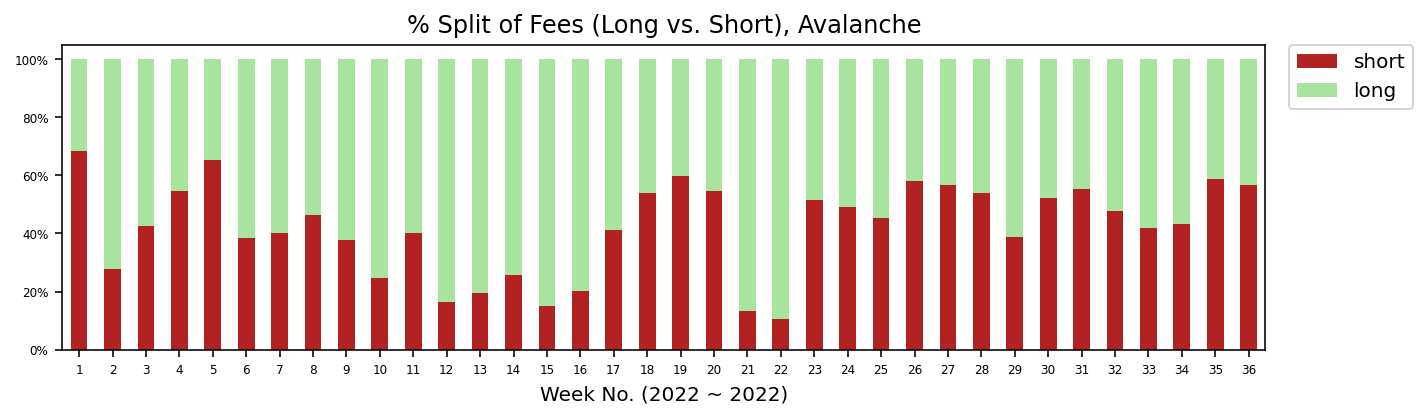

In [14]:
# title=tit+'\n'+subtit, ylabel='', xlabel='', 
ax = (da.loc[:, ['pct_short', 'pct_long']]
        .plot(kind='bar', stacked=True, rot=0, color=['#b22222', '#a8e4a0'], fontsize=6))
ax.set_xticklabels(da.index.get_level_values(1), fontsize=6)
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set(xlabel='Week No. '+period)
plt.title("% Split of Fees (Long vs. Short), {}".format(chain)) 
plt.legend(['short', 'long'], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'fees_long_vs_short.png'), dpi=300);